# Summary

Generate training and validation datasets.

----

# Imports

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.autograd import Variable

In [9]:
%run _imports.ipynb

Setting the PACKAGE_VERSION environment variable.
Setting the DOCS_SECRET_KEY environment variable.
Setting the PYTHON_VERSION environment variable.
Setting the SPARK_MASTER environment variable.
Setting the SPARK_ARGS environment variable.
Setting the DB_TYPE environment variable.
Setting the DB_PORT environment variable.


2018-05-03 18:54:52.111095


In [10]:
%run _settings.ipynb

In [11]:
import random
from typing import NamedTuple

import h5py
from sklearn import metrics

In [12]:
import pagnn
importlib.reload(pagnn)

<module 'pagnn' from '/home/kimlab1/strokach/working/pagnn/pagnn/__init__.py'>

# Parameters

In [13]:
NOTEBOOK_NAME = 'generate_datasets'
NOTEBOOK_PATH = Path(NOTEBOOK_NAME).absolute()
NOTEBOOK_PATH.mkdir(exist_ok=True)

In [14]:
os.environ['DATABIN_DIR']

'/home/kimlab2/database_data/databin'

## All Parquet files

In [15]:
ADJACENCY_MATRIX_PARQUET_FILES = list(ADJACENCY_MATRIX_PATH.glob('**/*.parquet'))

In [16]:
ADJACENCY_MATRIX_PARQUET_FILES[:2]

[PosixPath('/home/kimlab2/database_data/databin/uniparc_domain/0.1/adjacency_matrix.parquet/database_id=G3DSA%3A1.10.10.400/part-00148-9097eabe-2bc3-48d9-aa6d-e84d92b8380c.c000.snappy.parquet'),
 PosixPath('/home/kimlab2/database_data/databin/uniparc_domain/0.1/adjacency_matrix.parquet/database_id=G3DSA%3A1.10.10.400/part-00019-9097eabe-2bc3-48d9-aa6d-e84d92b8380c.c000.snappy.parquet')]

In [17]:
!ls {ADJACENCY_MATRIX_PATH}

database_id=G3DSA%3A1.10.1000.11   database_id=G3DSA%3A2.70.40.20
database_id=G3DSA%3A1.10.100.10    database_id=G3DSA%3A2.70.50.30
database_id=G3DSA%3A1.10.10.10	   database_id=G3DSA%3A2.70.50.40
database_id=G3DSA%3A1.10.101.10    database_id=G3DSA%3A2.70.9.10
database_id=G3DSA%3A1.10.10.140    database_id=G3DSA%3A2.70.9.30
database_id=G3DSA%3A1.10.10.180    database_id=G3DSA%3A2.70.98.10
database_id=G3DSA%3A1.10.10.190    database_id=G3DSA%3A2.70.98.20
database_id=G3DSA%3A1.10.10.200    database_id=G3DSA%3A2.70.98.40
database_id=G3DSA%3A1.10.1020.10   database_id=G3DSA%3A2.90.10.10
database_id=G3DSA%3A1.10.10.250    database_id=G3DSA%3A3.10.100.10
database_id=G3DSA%3A1.10.1030.10   database_id=G3DSA%3A3.10.110.10
database_id=G3DSA%3A1.10.10.350    database_id=G3DSA%3A3.10.120.10
database_id=G3DSA%3A1.10.10.390    database_id=G3DSA%3A3.10.130.10
database_id=G3DSA%3A1.10.10.400    database_id=G3DSA%3A3.10.180.10
database_id=G3DSA%3A1.10.1040.10   database_id=G3DSA%3A3.10.200.10
databas

## All Gene3D domains

In [18]:
GENE3D_DOMAINS = sorted({op.basename(op.dirname(f)) for f in ADJACENCY_MATRIX_PARQUET_FILES})

random.seed(42)
random.shuffle(GENE3D_DOMAINS)
GENE3D_DOMAINS[:3]

['database_id=G3DSA%3A2.40.128.20',
 'database_id=G3DSA%3A3.50.40.10',
 'database_id=G3DSA%3A2.60.40.830']

In [26]:
with open(f'{NOTEBOOK_NAME}/gene3d_domains.pickle', 'wb') as fout:
    pickle.dump(GENE3D_DOMAINS, fout, pickle.HIGHEST_PROTOCOL)

## Training / validation domains

In [21]:
breakpoint1 = len(GENE3D_DOMAINS) * 3 // 4
print(breakpoint1)
breakpoint2 = len(GENE3D_DOMAINS) * 7 // 8
print(breakpoint2)

TRAINING_DOMAINS = GENE3D_DOMAINS[:breakpoint1]
VALIDATION_DOMAINS = GENE3D_DOMAINS[breakpoint1:breakpoint2]
TEST_DOMAINS = GENE3D_DOMAINS[breakpoint2:]

print('----')
print(len(GENE3D_DOMAINS))
print(len(TRAINING_DOMAINS))
print(len(VALIDATION_DOMAINS))
print(len(TEST_DOMAINS))

1029
1201
----
1373
1029
172
172


In [28]:
assert (len(TRAINING_DOMAINS) + len(VALIDATION_DOMAINS) + len(TEST_DOMAINS)) == len(GENE3D_DOMAINS)

In [29]:
with open(f'{NOTEBOOK_NAME}/training_domains.pickle', 'wb') as fout:
    pickle.dump(TRAINING_DOMAINS, fout, pickle.HIGHEST_PROTOCOL)
    
with open(f'{NOTEBOOK_NAME}/validation_domains.pickle', 'wb') as fout:
    pickle.dump(VALIDATION_DOMAINS, fout, pickle.HIGHEST_PROTOCOL)
    
with open(f'{NOTEBOOK_NAME}/test_domains.pickle', 'wb') as fout:
    pickle.dump(TEST_DOMAINS, fout, pickle.HIGHEST_PROTOCOL)

## Training / validation parquet files

In [30]:
_training_domains = set(TRAINING_DOMAINS)
TRAINING_PARQUET_FILES = [
    f for f in ADJACENCY_MATRIX_PARQUET_FILES if op.basename(op.dirname(f)) in _training_domains]

In [31]:
_validation_domains = set(VALIDATION_DOMAINS)
VALIDATION_PARQUET_FILES = [
    f for f in ADJACENCY_MATRIX_PARQUET_FILES if op.basename(op.dirname(f)) in _validation_domains]

In [32]:
_test_domains = set(TEST_DOMAINS)
TEST_PARQUET_FILES = [
    f for f in ADJACENCY_MATRIX_PARQUET_FILES if op.basename(op.dirname(f)) in _test_domains]

In [33]:
assert (
    len(TRAINING_PARQUET_FILES) + 
    len(VALIDATION_PARQUET_FILES) +
    len(TEST_PARQUET_FILES)) == len(ADJACENCY_MATRIX_PARQUET_FILES)

In [34]:
with open(f'{NOTEBOOK_NAME}/training_parquet_files.pickle', 'wb') as fout:
    pickle.dump(TRAINING_PARQUET_FILES, fout, pickle.HIGHEST_PROTOCOL)
    
with open(f'{NOTEBOOK_NAME}/validation_parquet_files.pickle', 'wb') as fout:
    pickle.dump(VALIDATION_PARQUET_FILES, fout, pickle.HIGHEST_PROTOCOL)
    
with open(f'{NOTEBOOK_NAME}/test_parquet_files.pickle', 'wb') as fout:
    pickle.dump(TEST_PARQUET_FILES, fout, pickle.HIGHEST_PROTOCOL)

## Output folders

In [35]:
VALIDATION_DIR = NOTEBOOK_PATH.joinpath('validation')
VALIDATION_DIR.mkdir(exist_ok=True)
VALIDATION_DIR

PosixPath('/home/kimlab2/database_data/biological-data-warehouse/adjacency-net/notebooks/generate_datasets/validation')

In [36]:
PROTHERM_DIR = NOTEBOOK_PATH.joinpath('protherm')
PROTHERM_DIR.mkdir(exist_ok=True)
PROTHERM_DIR

PosixPath('/home/kimlab2/database_data/biological-data-warehouse/adjacency-net/notebooks/generate_datasets/protherm')

In [37]:
HUMSAVAR_DIR = NOTEBOOK_PATH.joinpath('humsavar')
HUMSAVAR_DIR.mkdir(exist_ok=True)
HUMSAVAR_DIR

PosixPath('/home/kimlab2/database_data/biological-data-warehouse/adjacency-net/notebooks/generate_datasets/humsavar')

# Datasets

## Internal validation dataset

In [38]:
VALIDATION_DOMAINS[:2]

['database_id=G3DSA%3A1.10.170.10', 'database_id=G3DSA%3A2.40.380.10']

In [39]:
validation_domain_folders = [
    ADJACENCY_MATRIX_PATH.joinpath(domain)
    for domain in VALIDATION_DOMAINS
]

In [40]:
validation_domain_folders[:2]

[PosixPath('/home/kimlab2/database_data/databin/uniparc_domain/0.1/adjacency_matrix.parquet/database_id=G3DSA%3A1.10.170.10'),
 PosixPath('/home/kimlab2/database_data/databin/uniparc_domain/0.1/adjacency_matrix.parquet/database_id=G3DSA%3A2.40.380.10')]

In [41]:
validation_domain_weights_file = NOTEBOOK_PATH.joinpath('validation_domain_weights.pickle')

if validation_domain_weights_file.is_file():
    with validation_domain_weights_file.open('rb') as fin:
        validation_domain_weights = pickle.load(fin)
else:
    validation_domain_weights = []
    for domain_folder in tqdm.tqdm_notebook(validation_domain_folders, total=len(validation_domain_folders)):
        count = pagnn.count_domain_rows(domain_folder)
        validation_domain_weights.append(count)
    with validation_domain_weights_file.open('wb') as fout:
        pickle.dump(validation_domain_weights, fout)

In [42]:
validation_domain_weights[:2]

[156, 9093]

### Shifted matrix validation

In [32]:
if VALIDATION_DIR.joinpath('validation.parquet').is_file():
    raise Exception("Validation dataset already exists!")

Exception: Validation dataset already exists!

In [32]:
random.seed(42)
np.random.seed(42)

validation_df = pd.DataFrame(
    data=list(itertools.islice(
        pagnn.iter_dataset_rows(validation_domain_folders, validation_domain_weights),
        100_000)))

In [33]:
validation_df.head(2)

,Index,qseq,residue_idx_1_corrected,residue_idx_2_corrected
0,425,WRLVEVGRVVVINGDHPYAGGLATIVEIIDHKRVLVDGPSANTELAVPRQSVPLAKCLLSQFVVEGLLRGSRNGTVKKLWEKCEIDTKW,"[0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, ...","[1.0, 2.0, 0.0, 2.0, 3.0, 7.0, 57.0, 58.0, 59.0, 60.0, 0.0, 1.0, 3.0, 4.0, 7.0, 58.0, 1.0, 2.0, 4.0, 5.0, 7.0, 24.0,..."
1,1714,WAGDITYLMSSEGWLYLAVIIDLYSRSVVGWSMNTKMTAD,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 3.0, 3.0, ...","[1.0, 2.0, 22.0, 23.0, 24.0, 25.0, 26.0, 0.0, 2.0, 3.0, 22.0, 23.0, 24.0, 0.0, 1.0, 3.0, 4.0, 20.0, 21.0, 22.0, 23.0..."


In [34]:
VALIDATION_DIR.mkdir(exist_ok=True)

pq.write_table(
    pa.Table.from_pandas(validation_df),
    VALIDATION_DIR.joinpath('validation.parquet').as_posix(),
#     row_group_size=10_000,
    version='2.0',
    flavor='spark',
)

### Matching start domain boundary

In [43]:
validation_domain_folders[:1]

[PosixPath('/home/kimlab2/database_data/databin/uniparc_domain/0.1/adjacency_matrix.parquet/database_id=G3DSA%3A1.10.170.10')]

In [44]:
df = pq.read_table(validation_domain_folders[0].as_posix()).to_pandas()

In [46]:
df.head(1)

,uniparc_id,sequence,database,interpro_name,interpro_id,domain_start,domain_end,__index_level_0__,domain_length,structure_id,model_id,chain_id,pc_identity,alignment_length,mismatches,gap_opens,q_start,q_end,s_start,s_end,evalue_log10,bitscore,qseq,sseq,a2b,b2a,residue_idx_1,residue_idx_2,residue_id_1,residue_id_2,residue_aa_1,residue_aa_2,residue_idx_1_corrected,residue_idx_2_corrected
0,UPI00042EB505,RIVYDSMEADILAVYTYRDEFWDSLRSYVLQTLGVPAHHYPTRPVTEFRQNLAIAILSRLFDVYCAMAPEINPPVAAQGVVGGLAHRLQAA,Gene3D,"Orbivirus inner capsid protein VP7, C-terminal",IPR023178,257,347,622086831,91,1BVP,0.0,A,34.33,67.0,44.0,0.0,4.0,70.0,260.0,326.0,-2.69897,36.6,YDSMEADILAVYTYRDEFWDSLRSYVLQTLGVPAHHYPTRPVTEFRQNLAIAILSRLFDVYCAMAPE,YPALTAEIFNVYSFRDHTWHGLRTAILNRTTLPNMLPPIFPPNDRDSILTLLLLSTLADVYTVLRPE,"[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0...","[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0...","[259.0, 259.0, 259.0, 259.0, 259.0, 260.0, 260.0, 260.0, 260.0, 261.0, 261.0, 261.0, 261.0, 261.0, 261.0, 262.0, 262...","[260.0, 261.0, 262.0, 306.0, 310.0, 259.0, 261.0, 262.0, 265.0, 259.0, 260.0, 262.0, 263.0, 264.0, 265.0, 259.0, 260...","[260.0, 260.0, 260.0, 260.0, 260.0, 261.0, 261.0, 261.0, 261.0, 262.0, 262.0, 262.0, 262.0, 262.0, 262.0, 263.0, 263...","[261.0, 262.0, 263.0, 307.0, 311.0, 260.0, 262.0, 263.0, 266.0, 260.0, 261.0, 263.0, 264.0, 265.0, 266.0, 260.0, 261...","[Y, Y, Y, Y, Y, P, P, P, P, A, A, A, A, A, A, L, L, L, L, L, L, L, L, L, L, L, L, T, T, T, T, T, T, T, A, A, A, A, A...","[P, A, L, I, L, Y, A, L, E, Y, P, L, T, A, E, Y, P, A, T, A, E, I, F, P, I, L, L, A, L, A, E, I, F, N, A, L, T, E, I...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, ...","[1.0, 2.0, 3.0, 47.0, 51.0, 0.0, 2.0, 3.0, 6.0, 0.0, 1.0, 3.0, 4.0, 5.0, 6.0, 0.0, 1.0, 2.0, 4.0, 5.0, 6.0, 7.0, 8.0..."


In [47]:
import pagnn.validation_set

In [49]:
random.seed(42)
np.random.seed(42)


class AdjacenciesTooGenericError(Exception):
    pass


class OtherRow(NamedTuple):
    #
    qseq: str
    residue_idx_1_corrected: list
    residue_idx_2_corrected: list
    pc_identity: str
    #
    negative_qseq: str
    negative_residue_idx_1_corrected: list
    negative_residue_idx_2_corrected: list
    #
    negative_seq_identity: float
    negative_adj_identity: float


def get_validation_df(match_type, n_rows=100_000, max_skips=124):
    assert match_type in ['start', 'stop', 'random', 'random-middle']
    
    validation_rows = []
    
    n_pc_identity_skips = 0
    n_seq_too_short_skips = 0
    n_negative_seq_identity_skips = 0
    n_negative_adj_identity_skips = 0

    with tqdm.tqdm_notebook(desc=match_type, total=n_rows) as progress:
        row2_iterator = iter_forever(
            lambda: pagnn.iter_dataset_rows(
                validation_domain_folders,
                validation_domain_weights, ('pc_identity', )))

        for row1 in pagnn.iter_dataset_rows(
                validation_domain_folders,
                validation_domain_weights, ('pc_identity', )):

            if len(validation_rows) >= n_rows:
                break

            if row1.pc_identity < 80:
                n_pc_identity_skips += 1
                continue
        
            row1 = row1._asdict()
            row1['qseq'] = row1['qseq'].replace('-', '')
            
            if len(row1['qseq']) < 24:
                n_seq_too_short_skips += 1
                continue
            
            n_skips = 0

            for row2 in row2_iterator:
                if n_skips > max_skips:
                    break

                if row2.pc_identity < 80:
                    continue

                row2 = row2._asdict()
                row2['qseq'] = row2['qseq'].replace('-', '')

                if len(row2['qseq']) < (len(row1['qseq']) + (20 if match_type.startswith('random') else 0)):
                    n_skips += 1
                    continue

                pos = row1

                if match_type in ['start', 'stop', 'random']:
                    start, stop = pagnn.validation_set.edge_indices(
                        pos['qseq'], row2['qseq'], match_type)
                    pos['negative_qseq'] = pagnn.validation_set.cut_sequence_from_edges(
                        start, stop, pos['qseq'], row2['qseq'])
                    pos['negative_residue_idx_1_corrected'], pos['negative_residue_idx_2_corrected'] = (
                        pagnn.validation_set.cut_adjacency_from_edges(
                            start, stop, row2['residue_idx_1_corrected'], row2['residue_idx_2_corrected'])
                    )
                elif match_type in ['random-middle']:
                    try:
                        stop, start = pagnn.validation_set.middle_indices(
                            pos['qseq'], row2['qseq'], match_type)
                    except pagnn.validation_set.SequenceTooShortError:
                        n_skips += 1
                        continue
                    pos['negative_qseq'] = pagnn.validation_set.cut_sequence_from_middle(
                        stop, start, pos['qseq'], row2['qseq'])
                    pos['negative_residue_idx_1_corrected'], pos['negative_residue_idx_2_corrected'] = (
                        pagnn.validation_set.cut_adjacency_from_middle(
                            stop, start, row2['residue_idx_1_corrected'], row2['residue_idx_2_corrected'])
                    )
                else:
                    raise Exception

                if (not pos['negative_residue_idx_1_corrected'] or not pos['negative_residue_idx_2_corrected']):
                    print(f"Error: got nevative adjacencies "
                          f"({pos['negative_residue_idx_1_corrected']})"
                          f"({pos['negative_residue_idx_2_corrected']})")
                    n_skips += 1
                    continue

                assert len(pos['negative_qseq']) == len(pos['qseq'])
                assert min(pos['negative_residue_idx_1_corrected']) >= 0
                assert min(pos['negative_residue_idx_2_corrected']) >= 0
                assert max(pos['negative_residue_idx_1_corrected']) < len(pos['qseq'])
                assert max(pos['negative_residue_idx_2_corrected']) < len(pos['qseq'])

                pos['negative_seq_identity'] = get_seq_identity(pos['qseq'], pos['negative_qseq'])
                
                if pos['negative_seq_identity'] > 0.2:
                    n_negative_seq_identity_skips += 1
                    continue

                try:
                    pos['negative_adj_identity'] = get_adj_identity(
                        pos['residue_idx_1_corrected'], pos['residue_idx_2_corrected'],
                        pos['negative_residue_idx_1_corrected'], pos['negative_residue_idx_2_corrected'])
                except AdjacenciesTooGenericError:
                    break

                if pos['negative_adj_identity'] > 0.2:
                    n_negative_adj_identity_skips += 1
                    continue

                validation_row = OtherRow(*(pos[key] for key in OtherRow._fields))
                validation_rows.append(validation_row)
                break
            progress.update()


    stats = dict(
        n_pc_identity_skips=n_pc_identity_skips,
        n_seq_too_short_skips=n_seq_too_short_skips,
        n_negative_seq_identity_skips=n_negative_seq_identity_skips,
        n_negative_adj_identity_skips=n_negative_adj_identity_skips,
    )
    return pd.DataFrame(validation_rows), stats

In [51]:
VALIDATION_DFS = {}
# for match_type in ['start', 'stop', 'random', 'random-middle']:
for match_type in ['random', 'random-middle']:
    VALIDATION_DFS[match_type], stats = get_validation_df(match_type, 100_000)
    pprint(stats)

HBox(children=(IntProgress(value=0, description='random', max=100000), HTML(value='')))

Error: got nevative adjacencies ([])([])
Error: got nevative adjacencies ([])([])
Error: got nevative adjacencies ([])([])
Error: got nevative adjacencies ([])([])

{'n_negative_adj_identity_skips': 245238,
 'n_negative_seq_identity_skips': 142,
 'n_pc_identity_skips': 1626695,
 'n_seq_too_short_skips': 1654}


HBox(children=(IntProgress(value=0, description='random-middle', max=100000), HTML(value='')))


{'n_negative_adj_identity_skips': 337055,
 'n_negative_seq_identity_skips': 446,
 'n_pc_identity_skips': 1631842,
 'n_seq_too_short_skips': 1718}


**start:**

`100% 100000/100000 [2:35:42<00:00, 10.70it/s]`

```json
{'n_negative_adj_identity_skips': 158778,
 'n_negative_seq_identity_skips': 3803,
 'n_pc_identity_skips': 1608060,
 'n_seq_too_short_skips': 1645}
```

**stop:**

`100% 100000/100000 [3:23:41<00:00, 8.18it/s]`

```json
{'n_negative_adj_identity_skips': 381227,
 'n_negative_seq_identity_skips': 3349,
 'n_pc_identity_skips': 1610602,
 'n_seq_too_short_skips': 1584}
```


**random:**

`101916it [2:23:05, 15.58it/s]`

```json
{'n_negative_adj_identity_skips': 245238,
 'n_negative_seq_identity_skips': 142,
 'n_pc_identity_skips': 1626695,
 'n_seq_too_short_skips': 1654}
```

**random-middle:**

`102362it [2:52:00, 9.92it/s]`

```json
{'n_negative_adj_identity_skips': 337055,
 'n_negative_seq_identity_skips': 446,
 'n_pc_identity_skips': 1631842,
 'n_seq_too_short_skips': 1718}
```

In [56]:
!ls {NOTEBOOK_NAME}/validation -lSh

total 2.8G
-rw-r--r-- 1 strokach kimlab 637M Jan 20 14:00 validation_start.parquet
-rw-r--r-- 1 strokach kimlab 633M Jan 20 14:03 validation_stop.parquet
-rw-r--r-- 1 strokach kimlab 625M Jan 22 11:46 validation_random-middle.parquet
-rw-r--r-- 1 strokach kimlab 624M Jan 22 11:43 validation_random.parquet
-rw-r--r-- 1 strokach kimlab 297M Jan  8 17:26 validation.parquet


In [55]:
for match_type in ['random', 'random-middle']:
    pq.write_table(
        pa.Table.from_pandas(VALIDATION_DFS[match_type]),
        VALIDATION_DIR.joinpath(f'validation_{match_type}.parquet').as_posix(),
        row_group_size=10_000,
        version='2.0', flavor='spark',
    )

In [57]:
f = pq.ParquetFile(VALIDATION_DIR.joinpath(f'validation_random-middle.parquet').as_posix())

In [58]:
f.num_row_groups

10

### Matching end domain boundary

## External validation dataset

### Uniparc xref

In [35]:
uniparc_xref_file = op.join(os.environ['DATABIN_DIR'], 'uniparc', 'v0.1.0', 'uniparc_xref.parquet')
uniparc_xref_file

'/home/kimlab2/database_data/databin/uniparc/v0.1.0/uniparc_xref.parquet'

In [36]:
!ls {uniparc_xref_file} -lSh

-rw-rw-rw- 1 strokach kimlab 16G Nov 15 12:48 /home/kimlab2/database_data/databin/uniparc/v0.1.0/uniparc_xref.parquet


In [37]:
ds = spark.sql(f"""\
SELECT *
FROM parquet.`{uniparc_xref_file}`
""")

In [38]:
ds.limit(10).toPandas()

,uniparc_id,idx,db_type,db_id,version_i,active,version,created,last,__index_level_0__
0,UPI0000000011,1,PRF,3119392DP,1,Y,NaN,2006-02-13,2009-09-01,0
1,UPI0000000011,2,PRF,3119392TK,1,Y,NaN,2006-02-13,2009-09-01,1
2,UPI0000000011,3,PRF,3121328BV,1,Y,NaN,2006-02-13,2009-09-01,2
3,UPI0000000011,4,PRF,3216358CT,1,Y,NaN,2007-01-01,2009-09-01,3
4,UPI0000000011,5,PRF,3216358FBB,1,Y,NaN,2007-01-01,2009-09-01,4
5,UPI0000000011,6,PRF,3315290CD,1,Y,NaN,2007-12-07,2009-09-01,5
6,UPI0000000011,7,EMBL,AAA48061,1,Y,1.0,2003-03-12,2017-05-26,6
7,UPI0000000011,8,EMBL,AAB96437,1,Y,1.0,2003-03-12,2017-05-26,7
8,UPI0000000011,9,EMBL,AAQ93171,1,Y,1.0,2006-05-04,2017-05-26,8
9,UPI0000000011,10,EMBL,AAR17917,1,Y,1.0,2006-05-04,2017-05-26,9


In [39]:
# 'UniProtKB/Swiss-Prot' | 'UniProtKB/TrEMBL'
# active = 'Y'
# db_id = ''

### Adjacency matrix

In [40]:
ADJACENCY_MATRIX_PATH

PosixPath('/home/kimlab2/database_data/databin/uniparc_domain/0.1/adjacency_matrix.parquet')

In [42]:
ds = spark.sql(f"""\
SELECT *
FROM parquet.`{ADJACENCY_MATRIX_PATH}`
""")

In [43]:
ds.limit(10).toPandas()

,uniparc_id,sequence,database,interpro_name,interpro_id,domain_start,domain_end,__index_level_0__,domain_length,structure_id,model_id,chain_id,pc_identity,alignment_length,mismatches,gap_opens,q_start,q_end,s_start,s_end,evalue_log10,bitscore,qseq,sseq,a2b,b2a,residue_idx_1,residue_idx_2,residue_id_1,residue_id_2,residue_aa_1,residue_aa_2,residue_idx_1_corrected,residue_idx_2_corrected,database_id
0,UPI000AF78023,AAAALLPLAASAAPARGTLLKSSVLSSYTSQAIGTLLANAQSTDQAKCDVRLAEFTYATIGVNGEPATASGTLLVPGGSQCAGPFPLVSYSQGTESLRHAEQAKEIRDAKGDDTIV...,Gene3D,Alpha/Beta hydrolase fold,IPR029058,11,287,700874249,277,3H2G,0.0,A,74.24,264.0,65.0,1.0,14.0,277.0,1.0,261.0,-143.000000,414.0,PARGTLLKSSVLSSYTSQAIGTLLANAQSTDQAKCDVRLAEFTYATIGVNGEPATASGTLLVPGGSQCAGPFPLVSYSQGTESLRHAEQAKEIRDAKGDDTIVTHLATQGYVVVSS...,PARGTLLTSNFLTSYTRDAISAMLA---SPEQAKCNVRVAEFTYATIGVEGEPATASGVLLIPGGERCSGPYPLLGWGHPTEALRAQEQAKEIRDAKGDDPLVTRLASQGYVVVGS...,"[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0...","[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 3.0, 3.0, ...","[1.0, 2.0, 4.0, 6.0, 41.0, 0.0, 2.0, 3.0, 4.0, 41.0, 0.0, 1.0, 3.0, 4.0, 41.0, 42.0, 43.0, 135.0, 138.0, 139.0, 142....","[2.0, 2.0, 2.0, 2.0, 2.0, 3.0, 3.0, 3.0, 3.0, 3.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 5.0, 5.0, ...","[3.0, 4.0, 6.0, 8.0, 52.0, 2.0, 4.0, 5.0, 6.0, 52.0, 2.0, 3.0, 5.0, 6.0, 52.0, 53.0, 54.0, 146.0, 149.0, 150.0, 153....","[P, P, P, P, P, A, A, A, A, A, R, R, R, R, R, R, R, R, R, R, R, G, G, G, G, G, G, G, G, G, G, G, T, T, T, T, T, T, T...","[A, R, T, L, A, P, R, G, T, A, P, A, G, T, A, T, I, S, I, D, R, A, R, T, L, Y, A, T, D, R, A, S, P, A, R, G, L, L, T...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 3.0, 3.0, ...","[1.0, 2.0, 4.0, 6.0, 44.0, 0.0, 2.0, 3.0, 4.0, 44.0, 0.0, 1.0, 3.0, 4.0, 44.0, 45.0, 46.0, 138.0, 141.0, 142.0, 145....",G3DSA:3.40.50.1820
1,UPI0009F3B2EE,AAAAPRPPPAGRRPGRVSARTHHYGPHRHGPHPDQFLELTLPSGDGPAPVAVVLHGGFWRAAYGIELARPLAADLAAAGWAAVAVEYRRGGTGGWSAPLEDVAAALDALPGLAERD...,Gene3D,Alpha/Beta hydrolase fold,IPR029058,83,355,756058084,273,5AOA,0.0,A,27.86,201.0,134.0,4.0,52.0,249.0,43.0,235.0,-6.096910,50.4,VVLHGGFWRAAYGIELARPLAADLAAAGWAAVAVEYRRGGTGGWSA--PLEDVAAALDALPGLAERDRLDLADLTVVGHSAGGHLAAWAAGRGRLPDGAPGAGPRVRVTAAVLQAG...,VFFFGGGWQSGSPAQF-RPQCEYFAGRGMVAMAADYRVGSRHNVKVADCVADAKSAIRWVRQHAAELGVDPQKIVASGGSAGGHLAACTVMVPDLEAPEEDHTISSQANAAILFNP...,"[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 18.0, 19.0, 20.0, 21.0, 22.0...","[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, None, 17.0, 18.0, 19.0, 20.0...","[42.0, 42.0, 42.0, 42.0, 42.0, 42.0, 42.0, 42.0, 42.0, 42.0, 42.0, 43.0, 43.0, 43.0, 43.0, 43.0, 43.0, 43.0, 43.0, 4...","[43.0, 44.0, 72.0, 74.0, 96.0, 97.0, 100.0, 114.0, 115.0, 116.0, 117.0, 42.0, 44.0, 45.0, 57.0, 60.0, 61.0, 64.0, 71...","[48.0, 48.0, 48.0, 48.0, 48.0, 48.0, 48.0, 48.0, 48.0, 48.0, 48.0, 49.0, 49.0, 49.0, 49.0, 49.0, 49.0, 49.0, 49.0, 4...","[49.0, 50.0, 78.0, 80.0, 102.0, 103.0, 106.0, 120.0, 121.0, 122.0, 123.0, 48.0, 50.0, 51.0, 63.0, 66.0, 67.0, 70.0, ...","[V, V, V, V, V, V, V, V, V, V, V, F, F, F, F, F, F, F, F, F, F, F, F, F, F, F, F, F, F, F, F, F, F, F, F, F, F, F, F...","[F, F, M, A, A, I, V, I, V, A, S, V, F, F, F, Q, C, F, A, M, A, A, S, G, F, V, F, F, G, F, A, Y, A, A, I, A, S, G, G...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[1.0, 2.0, 31.0, 33.0, 53.0, 54.0, 57.0, 71.0, 72.0, 73.0, 74.0, 0.0, 2.0, 3.0, 15.0, 19.0, 20.0, 23.0, 30.0, 31.0, ...",G3DSA:3.40.50.1820
2,UPI0005F71968,AAAAVHLVVLQHGLWGTPQNLGALQERLEAALQALAGPERIVMENSAVNERRRTHDGIDTCGDRLAQLILARTAQLRLDGHRVA

### Protherm dataset

In [44]:
protherm_file = (
    op.join(os.environ['DATABIN_DIR'], 'protein_folding_energy', 'v0.1.0', 'protherm_star.parquet')
)

#### Examine file

In [45]:
protherm = pq.read_table(protherm_file).to_pandas().set_index('__index_level_0__')

In [46]:
display(protherm.head())
print(protherm.shape)

,pdb_id,pdb_chain,pdb_mutation,uniprot_id,uniprot_mutation,pfam_id,ddg_exp,ddg_exp_std,ddg_exp_count
__index_level_0__,,,,,,,,,
0,1a2p,A,A_A32C,P00648,A79C,PF00545,1.838100,NaN,1
1,1a2p,A,A_A32D,P00648,A79D,PF00545,0.414300,NaN,1
2,1a2p,A,A_A32E,P00648,A79E,PF00545,-0.132800,NaN,1
3,1a2p,A,A_A32F,P00648,A79F,PF00545,0.436800,NaN,1
4,1a2p,A,A_A32G,P00648,A79G,PF00545,0.860767,0.067954,3


(2997, 9)


In [47]:
protherm = protherm.dropna(subset=['uniprot_id', 'uniprot_mutation', 'ddg_exp'])

In [48]:
protherm.shape

(2997, 9)

#### Spark query

In [49]:
ADJACENCY_MATRIX_PATH

PosixPath('/home/kimlab2/database_data/databin/uniparc_domain/0.1/adjacency_matrix.parquet')

In [74]:
ds = spark.sql(f"""\
SELECT
    ds.uniprot_id, ds.uniprot_mutation, ds.ddg_exp,
    
    xref.uniparc_id,
    
    ud.sequence, ud.database_id, ud.domain_start, ud.domain_end, ud.__index_level_0__ domain_index,
       
    ud.structure_id, ud.model_id, ud.chain_id,
    ud.pc_identity, ud.alignment_length, ud.mismatches, ud.gap_opens, 
    ud.q_start, ud.q_end, ud.s_start, ud.s_end,
    
    ud.qseq, ud.sseq,
    ud.residue_idx_1_corrected, ud.residue_idx_2_corrected

FROM parquet.`{protherm_file}` ds
JOIN parquet.`{uniparc_xref_file}` xref ON (uniprot_id = db_id)
JOIN parquet.`{ADJACENCY_MATRIX_PATH}` ud USING (uniparc_id)
WHERE (xref.db_type = 'UniProtKB/Swiss-Prot' OR xref.db_type = 'UniProtKB/TrEMBL')
AND xref.active = 'Y'
""")

In [75]:
ds.write.parquet(
    PROTHERM_DIR.joinpath('protherm_2.parquet').as_posix(),
    mode='overwrite',
)

#### Remove mutations outside domains

In [280]:
protherm_df = pq.ParquetDataset(PROTHERM_DIR.joinpath('protherm_2.parquet').as_posix()).read().to_pandas()

Ignoring path: /home/kimlab2/database_data/biological-data-warehouse/adjacency-net/notebooks/generate_datasets/protherm/protherm_2.parquet/.part-00086-d8952653-c34f-49b3-a868-efb4cb14db54-c000.snappy.parquet.crc
Ignoring path: /home/kimlab2/database_data/biological-data-warehouse/adjacency-net/notebooks/generate_datasets/protherm/protherm_2.parquet/.part-00101-d8952653-c34f-49b3-a868-efb4cb14db54-c000.snappy.parquet.crc
Ignoring path: /home/kimlab2/database_data/biological-data-warehouse/adjacency-net/notebooks/generate_datasets/protherm/protherm_2.parquet/.part-00018-d8952653-c34f-49b3-a868-efb4cb14db54-c000.snappy.parquet.crc
Ignoring path: /home/kimlab2/database_data/biological-data-warehouse/adjacency-net/notebooks/generate_datasets/protherm/protherm_2.parquet/.part-00193-d8952653-c34f-49b3-a868-efb4cb14db54-c000.snappy.parquet.crc
Ignoring path: /home/kimlab2/database_data/biological-data-warehouse/adjacency-net/notebooks/generate_datasets/protherm/protherm_2.parquet/.part-00150-d

In [281]:
display(protherm_df.head(2))
print(protherm_df.shape[0])

,uniprot_id,uniprot_mutation,ddg_exp,uniparc_id,sequence,database_id,domain_start,domain_end,domain_index,structure_id,model_id,chain_id,pc_identity,alignment_length,mismatches,gap_opens,q_start,q_end,s_start,s_end,qseq,sseq,residue_idx_1_corrected,residue_idx_2_corrected
0,P08921,V100A,3.01,UPI0000127348,RDSGTVWGALGHGINLNIPNFQMTDDIDEVRWERGSTLVAEFKRKMKPFLKSGAFEILANGDLKIKNLTRDDSGTYNVTVYSTNGTRILDKALDLRILE,G3DSA:2.60.40.10,23,121,378750125,1HNG,0.0,A,98.98,98.0,1.0,0.0,2.0,99.0,1.0,98.0,DSGTVWGALGHGINLNIPNFQMTDDIDEVRWERGSTLVAEFKRKMKPFLKSGAFEILANGDLKIKNLTRDDSGTYNVTVYSTNGTRILDKALDLRILE,DSGTVWGALGHGINLNIPNFQMTDDIDEVRWERGSTLVAEFKRKMKPFLKSGAFEILANGDLKIKNLTRDDSGTYNVTVYSTNGTRILNKALDLRILE,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, ...","[1.0, 2.0, 88.0, 89.0, 90.0, 0.0, 2.0, 3.0, 90.0, 91.0, 0.0, 1.0, 3.0, 4.0, 90.0, 91.0, 92.0, 1.0, 2.0, 4.0, 5.0, 92..."
1,P08921,V100A,3.01,UPI0000127348,MVSKPMIYWECSNATLTCEVLEGTDVELKLYQGKEHLRSLRQKTMSYQWTNLRAPFKCKAVNRVSQESEMEVVNCPE,G3DSA:2.60.40.10,122,198,378750126,1CCZ,0.0,A,100.00,77.0,0.0,0.0,1.0,77.0,95.0,171.0,MVSKPMIYWECSNATLTCEVLEGTDVELKLYQGKEHLRSLRQKTMSYQWTNLRAPFKCKAVNRVSQESEMEVVNCPE,MVSKPMIYWECSNATLTCEVLEGTDVELKLYQGKEHLRSLRQKTMSYQWTNLRAPFKCKAVNRVSQESEMEVVNCPE,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, ...","[1.0, 2.0, 21.0, 22.0, 61.0, 63.0, 64.0, 0.0, 2.0, 3.0, 19.0, 21.0, 22.0, 25.0, 59.0, 60.0, 61.0, 64.0, 65.0, 66.0, ..."


416


In [282]:
importlib.reload(pagnn.utils)

<module 'pagnn.utils' from '/home/kimlab1/strokach/working/pagnn/pagnn/utils/__init__.py'>

In [283]:
protherm_df = pagnn.filter_mismatch_mutations(protherm_df)

Removing 10 rows containing mutations that are outside domains.
Removing 0 rows containing mutations do not match sequence.
Removing 0 rows containing mutations that are outside alignment with structure.


In [284]:
protherm_df.shape[0]

406

(array([   1.,   21.,  187.,  114.,   60.,   17.,    4.,    0.,    1.,    1.]),
 array([ -4.   ,  -2.377,  -0.754,   0.869,   2.492,   4.115,   5.738,
          7.361,   8.984,  10.607,  12.23 ]),
 <a list of 10 Patch objects>)

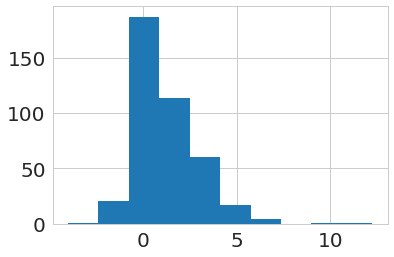

In [285]:
plt.hist(protherm_df['ddg_exp'])

In [286]:
pq.write_table(
    pa.Table.from_pandas(protherm_df, preserve_index=False),
    PROTHERM_DIR.joinpath('protherm_final.parquet').as_posix(),
    version='2.0',
    flavor='spark',
)

In [287]:
PROTHERM_DIR

PosixPath('/home/kimlab2/database_data/biological-data-warehouse/adjacency-net/notebooks/generate_datasets/protherm')

### Humsavar dataset

In [77]:
humsavar_file = (
    op.join(os.environ['DATABIN_DIR'], 'mutation_sets', 'v0.1.0', 'humsavar.parquet')
)

#### Examine file

In [78]:
humsavar = pq.read_table(humsavar_file).to_pandas().set_index('__index_level_0__')

In [79]:
display(humsavar.head())
print(humsavar.shape)

,hgnc_id,uniprot_id,swissvar_id,aa_change,type_of_variant,dbsnp_id,disease,uniprot_mutation
__index_level_0__,,,,,,,,
0,A1BG,P04217,VAR_018369,p.His52Arg,Polymorphism,rs893184,None,H52R
1,A1BG,P04217,VAR_018370,p.His395Arg,Polymorphism,rs2241788,None,H395R
2,A1CF,Q9NQ94,VAR_052201,p.Val555Met,Polymorphism,rs9073,None,V555M
3,A1CF,Q9NQ94,VAR_059821,p.Ala558Ser,Polymorphism,rs11817448,None,A558S
4,A2ML1,A8K2U0,VAR_055463,p.Gly207Arg,Polymorphism,rs11047499,None,G207R


(77598, 8)


In [80]:
humsavar = humsavar.dropna(subset=['uniprot_id', 'uniprot_mutation', 'type_of_variant'])

In [81]:
humsavar.shape

(77598, 8)

#### Spark query

In [83]:
ds = spark.sql(f"""\
SELECT
    ds.uniprot_id, ds.uniprot_mutation, ds.type_of_variant,
    
    xref.uniparc_id,
    
    ud.sequence, ud.database_id, ud.domain_start, ud.domain_end, ud.__index_level_0__ domain_index,
       
    ud.structure_id, ud.model_id, ud.chain_id,
    ud.pc_identity, ud.alignment_length, ud.mismatches, ud.gap_opens, 
    ud.q_start, ud.q_end, ud.s_start, ud.s_end,
    
    ud.qseq, ud.sseq,
    ud.residue_idx_1_corrected, ud.residue_idx_2_corrected

FROM parquet.`{humsavar_file}` ds
JOIN parquet.`{uniparc_xref_file}` xref ON (uniprot_id = db_id)
JOIN parquet.`{ADJACENCY_MATRIX_PATH}` ud USING (uniparc_id)
WHERE (xref.db_type = 'UniProtKB/Swiss-Prot' OR xref.db_type = 'UniProtKB/TrEMBL')
AND xref.active = 'Y'
""")

In [ ]:
# ds.limit(10).toPandas()

In [ ]:
ds.write.parquet(
    HUMSAVAR_DIR.joinpath('humsavar_2.parquet').as_posix(),
    mode='overwrite',
)

#### Remove mutations outside domains

In [270]:
humsavar_df = pq.ParquetDataset(HUMSAVAR_DIR.joinpath('humsavar_2.parquet').as_posix()).read().to_pandas()

Ignoring path: /home/kimlab2/database_data/biological-data-warehouse/adjacency-net/notebooks/generate_datasets/humsavar/humsavar_2.parquet/.part-00090-1663e553-a4f1-4a3b-a3fd-6fb81e009706-c000.snappy.parquet.crc
Ignoring path: /home/kimlab2/database_data/biological-data-warehouse/adjacency-net/notebooks/generate_datasets/humsavar/humsavar_2.parquet/.part-00182-1663e553-a4f1-4a3b-a3fd-6fb81e009706-c000.snappy.parquet.crc
Ignoring path: /home/kimlab2/database_data/biological-data-warehouse/adjacency-net/notebooks/generate_datasets/humsavar/humsavar_2.parquet/.part-00084-1663e553-a4f1-4a3b-a3fd-6fb81e009706-c000.snappy.parquet.crc
Ignoring path: /home/kimlab2/database_data/biological-data-warehouse/adjacency-net/notebooks/generate_datasets/humsavar/humsavar_2.parquet/.part-00050-1663e553-a4f1-4a3b-a3fd-6fb81e009706-c000.snappy.parquet.crc
Ignoring path: /home/kimlab2/database_data/biological-data-warehouse/adjacency-net/notebooks/generate_datasets/humsavar/humsavar_2.parquet/.part-00136-1

In [271]:
display(humsavar_df.head(2))
print(humsavar_df.shape[0])

,uniprot_id,uniprot_mutation,type_of_variant,uniparc_id,sequence,database_id,domain_start,domain_end,domain_index,structure_id,model_id,chain_id,pc_identity,alignment_length,mismatches,gap_opens,q_start,q_end,s_start,s_end,qseq,sseq,residue_idx_1_corrected,residue_idx_2_corrected
0,P12271,M226K,Disease,UPI0000000C59,YPELFDSLSPEAVRCTIEAGYPGVLSSRDKYGRVVMLFNIENWQSQEITFDEILQAYCFILEKLLENEETQINGFCIIENFKGFTMQQAASLRTSDLRKMVDMLQDSFPARFKAIH...,G3DSA:3.40.525.10,124,305,322513294,3HY5,0.0,A,100.0,182.0,0.0,0.0,1.0,182.0,102.0,283.0,YPELFDSLSPEAVRCTIEAGYPGVLSSRDKYGRVVMLFNIENWQSQEITFDEILQAYCFILEKLLENEETQINGFCIIENFKGFTMQQAASLRTSDLRKMVDMLQDSFPARFKAIH...,YPELFDSLSPEAVRCTIEAGYPGVLSSRDKYGRVVMLFNIENWQSQEITFDEILQAYCFILEKLLENEETQINGFCIIENFKGFTMQQAASLRTSDLRKMVDMLQDSFPARFKAIH...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 3.0, 3.0, 3.0, ...","[1.0, 2.0, 3.0, 4.0, 97.0, 98.0, 101.0, 0.0, 2.0, 3.0, 4.0, 5.0, 0.0, 1.0, 3.0, 4.0, 5.0, 6.0, 54.0, 98.0, 0.0, 1.0,..."
1,P12271,R234W,Disease,UPI0000000C59,YPELFDSLSPEAVRCTIEAGYPGVLSSRDKYGRVVMLFNIENWQSQEITFDEILQAYCFILEKLLENEETQINGFCIIENFKGFTMQQAASLRTSDLRKMVDMLQDSFPARFKAIH...,G3DSA:3.40.525.10,124,305,322513294,3HY5,0.0,A,100.0,182.0,0.0,0.0,1.0,182.0,102.0,283.0,YPELFDSLSPEAVRCTIEAGYPGVLSSRDKYGRVVMLFNIENWQSQEITFDEILQAYCFILEKLLENEETQINGFCIIENFKGFTMQQAASLRTSDLRKMVDMLQDSFPARFKAIH...,YPELFDSLSPEAVRCTIEAGYPGVLSSRDKYGRVVMLFNIENWQSQEITFDEILQAYCFILEKLLENEETQINGFCIIENFKGFTMQQAASLRTSDLRKMVDMLQDSFPARFKAIH...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 3.0, 3.0, 3.0, ...","[1.0, 2.0, 3.0, 4.0, 97.0, 98.0, 101.0, 0.0, 2.0, 3.0, 4.0, 5.0, 0.0, 1.0, 3.0, 4.0, 5.0, 6.0, 54.0, 98.0, 0.0, 1.0,..."


14536


In [272]:
importlib.reload(pagnn.utils)

<module 'pagnn.utils' from '/home/kimlab1/strokach/working/pagnn/pagnn/utils/__init__.py'>

In [273]:
humsavar_df = pagnn.filter_mismatch_mutations(humsavar_df)

Removing 9808 rows containing mutations that are outside domains.
Removing 1 rows containing mutations do not match sequence.
Removing 894 rows containing mutations that are outside alignment with structure.


In [274]:
humsavar_df.shape[0]

3833

In [275]:
Counter(humsavar_df['type_of_variant'])

Counter({'Disease': 1876, 'Polymorphism': 1751, 'Unclassified': 206})

In [276]:
humsavar_df = humsavar_df[humsavar_df['type_of_variant'].isin({'Disease', 'Polymorphism'})]

In [277]:
print(humsavar_df.shape[0])

3627


In [278]:
humsavar_df['score_exp'] = (humsavar_df['type_of_variant'] == 'Disease').astype(int)

In [279]:
pq.write_table(
    pa.Table.from_pandas(humsavar_df, preserve_index=False),
    HUMSAVAR_DIR.joinpath('humsavar_final.parquet').as_posix(),
    version='2.0',
    flavor='spark',
)